# HARDWARE

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

"""
To change attributes:
1) Change ATTRIBUTE and you're good to go
"""
ATTRIBUTE = 'stg_temp_min'
COUNTER = '_template'
PARALLEL = 20
PARALLEL_EXTRACTION = 8
TRAIN_SIZE = 3
DEV_SIZE = 3
TEST_SIZE = 3

import os
import sys
sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')
snorkel_postgres = os.environ['SNORKELDB'].startswith('postgres')
print snorkel_postgres

True


In [2]:
import os
if snorkel_postgres:
    os.environ['SNORKELDBNAME'] = ATTRIBUTE + str(COUNTER)
    print os.system("dropdb " + os.environ['SNORKELDBNAME'])
    print os.system("createdb " + os.environ['SNORKELDBNAME'])
    print "SNORKELDBNAME = %s" % os.environ['SNORKELDBNAME']
else:
    try:
        os.remove('snorkel.db')
    except:
        pass

from snorkel import SnorkelSession
session = SnorkelSession()

256
0
SNORKELDBNAME = stg_temp_min_dry_run2


## Parsing

In [3]:
import os
if snorkel_postgres:
    from snorkel.async_parser import parse_corpus, HTMLParser, AsyncOmniParser
    print "Starting async parse..."
    
    # PARSE TRAIN
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_digikey/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_digikey/pdf/'
    doc_parser = HTMLParser()
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                     tabular=True, lingual=True,
                                     visual=True, pdf_path=pdf_path)
    %time corpus = parse_corpus(session, 'Hardware Train', docs_path,\
                                doc_parser, context_parser,\
                                max_docs=TRAIN_SIZE, parallel=PARALLEL)
    print "%s contains %d documents" % (corpus, len(corpus))
    
    # PARSE DEV
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/pdf/'
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                     tabular=True, lingual=True,
                                     visual=True, pdf_path=pdf_path)
    %time corpus = parse_corpus(session, 'Hardware Dev', docs_path,\
                                doc_parser, context_parser,\
                                max_docs=DEV_SIZE, parallel=PARALLEL)
    print "%s contains %d documents" % (corpus, len(corpus))
    
    if TEST_SIZE:
        # PARSE TEST
        docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/test/html/'
        pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/test/pdf/'
        context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                         tabular=True, lingual=True,
                                         visual=True, pdf_path=pdf_path)
        %time corpus = parse_corpus(session, 'Hardware Test', docs_path,\
                                    doc_parser, context_parser,\
                                    max_docs=TEST_SIZE, parallel=PARALLEL)
        print "%s contains %d documents" % (corpus, len(corpus))
else:
    from snorkel.parser import CorpusParser, HTMLParser, OmniParser
    from snorkel.utils import get_ORM_instance
    from snorkel.queries import split_corpus

    print "Starting sync parse..."
    # PARSE TRAIN
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_small/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/train_small/pdf/'
    doc_parser = HTMLParser(path=docs_path)
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                     tabular=True, lingual=True,
                                     visual=True, pdf_path=pdf_path)
    cp = CorpusParser(doc_parser, context_parser, max_docs=100)

    %time corpus = cp.parse_corpus(name='Hardware Train', session=session)
    print "%s contains %d documents" % corpus, len(corpus)

    session.add(corpus)
    session.commit()
    
    # PARSE DEV
    docs_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/html/'
    pdf_path = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/pdf/'
    doc_parser = HTMLParser(path=docs_path)
    context_parser = AsyncOmniParser(blacklist=['style'], flatten=['span','br'], 
                                 tabular=True, lingual=True,
                                 visual=True, pdf_path=pdf_path)
    cp = CorpusParser(doc_parser, context_parser, max_docs=125)

    %time corpus = cp.parse_corpus(name='Hardware Dev', session=session)
    print "%s contains %d documents" % (corpus, len(corpus))
    session.add(corpus)
    session.commit()

Starting async parse...
[========================================] 100%
CPU times: user 112 ms, sys: 100 ms, total: 212 ms
Wall time: 13.6 s
Corpus (Hardware Train) contains 3 documents
[========================================] 100%
CPU times: user 16 ms, sys: 156 ms, total: 172 ms
Wall time: 2.68 s
Corpus (Hardware Dev) contains 3 documents
[========================================] 100%
CPU times: user 48 ms, sys: 100 ms, total: 148 ms
Wall time: 5.06 s
Corpus (Hardware Test) contains 3 documents


### Save Corpus

In [4]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ corpus');

## Extraction

In [5]:
# # If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ corpus snorkel.db');

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

In [6]:
from snorkel.models import candidate_subclass

Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

### Define Matchers

In [7]:
from hardware_matchers import get_matcher

dict_path = os.environ['SNORKELHOME'] +\
    '/tutorials/tables/data/hardware/gold_raw/digikey_part_dictionary.csv'
part_matcher = get_matcher('part', dict_path)
attr_matcher = get_matcher(ATTRIBUTE)

Using combined matcher.


### Define ContextSpaces

In [8]:
from hardware_spaces import get_space
    
part_ngrams = get_space('part')
attr_ngrams = get_space(ATTRIBUTE)

### Define Candidate Throttler

In [9]:
from hardware_throttlers import get_throttler

throttler = get_throttler(ATTRIBUTE)
# throttler = None

### Run CandidateExtractor

In [10]:
from snorkel.models import Corpus
from snorkel.candidates import CandidateExtractor
from snorkel.utils import get_ORM_instance
from snorkel.async_candidates import parallel_extract

ce = CandidateExtractor(Part_Attr, 
                        [part_ngrams, attr_ngrams], 
                        [part_matcher, attr_matcher], 
                        throttler=throttler)

corpus_names = ['Hardware Train', 'Hardware Dev']
if TEST_SIZE:
    corpus_names.append('Hardware Test')
for corpus_name in corpus_names:
    corpus = get_ORM_instance(Corpus, session, corpus_name)
    print "Extracting Candidates from %s" % corpus
    %time candidates = parallel_extract(session, ce, corpus, \
                                        corpus_name + ' Candidates', \
                                        parallel=PARALLEL_EXTRACTION)
    session.add(candidates)
    print "%s contains %d Candidates" % (candidates, len(candidates))
session.commit()

Extracting Candidates from Corpus (Hardware Train)
[========================================] 100%
CPU times: user 36 ms, sys: 88 ms, total: 124 ms
Wall time: 11.8 s
Candidate Set (Hardware Train Candidates) contains 90 Candidates
Extracting Candidates from Corpus (Hardware Dev)
[========================================] 100%
CPU times: user 20 ms, sys: 40 ms, total: 60 ms
Wall time: 564 ms
Candidate Set (Hardware Dev Candidates) contains 23 Candidates
Extracting Candidates from Corpus (Hardware Test)
[========================================] 100%
CPU times: user 28 ms, sys: 36 ms, total: 64 ms
Wall time: 1.17 s
Candidate Set (Hardware Test Candidates) contains 11 Candidates


### Second Pass

In [11]:
# from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
# from snorkel.utils import get_ORM_instance
# from snorkel.models import Corpus

# corpus = get_ORM_instance(Corpus, session, 'Hardware Dev')

# # parts_by_doc = get_gold_parts_by_doc()
# parts_by_doc = get_manual_parts_by_doc(corpus.documents.all())
# # parts_by_doc = None

In [12]:
# import cPickle as pickle
# pickle_file = os.environ['SNORKELHOME'] + '/tutorials/tables/sandbox/parts_by_doc_dev.pkl'

# with open(pickle_file, 'w') as f:
#     pickle.dump(parts_by_doc, f)

In [13]:
import cPickle as pickle
pickle_file = os.environ['SNORKELHOME'] + '/tutorials/tables/sandbox/parts_by_doc_dev.pkl'
with open(pickle_file, 'r') as f:
    parts_by_doc = pickle.load(f)

### Assess Recall

In [14]:
from snorkel.models import Corpus, CandidateSet
from hardware_utils import entity_level_f1

corpus = get_ORM_instance(Corpus, session, 'Hardware Dev')
candidates = get_ORM_instance(CandidateSet, session, 'Hardware Dev Candidates')
gold_file = os.environ['SNORKELHOME'] + \
    '/tutorials/tables/data/hardware/dev/hardware_dev_gold.csv'
%time (ctp, cfp, cfn) = entity_level_f1(candidates, gold_file, ATTRIBUTE, corpus, parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.905
Corpus Recall    1.0
Corpus F1        0.95
----------------------------------------
TP: 19 | FP: 2 | FN: 0

CPU times: user 284 ms, sys: 100 ms, total: 384 ms
Wall time: 344 ms


In [15]:
from pprint import pprint
pprint(cfp)

[(u'LTSCS02912-1', u'BC846W-REV', u'-55'),
 (u'UTCLS03593-1', u'DTC114E-I', u'-55')]


In [16]:
pprint(cfn)

[]


In [17]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ candidates');

## Gold Labels

In [18]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ candidates snorkel.db');

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

In [19]:
import os
from snorkel.models import CandidateSet
from hardware_utils import load_hardware_labels

data_sets = ['Dev']
gold_file = {}
gold_file['Dev'] = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/hardware_dev_gold.csv'
if TEST_SIZE:
    data_sets.append('Test')
    gold_file['Test'] = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/test/hardware_test_gold.csv'
for data_set in data_sets:
    candidate_set_name = 'Hardware %s Candidates' % data_set
    candidates = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name).one()
    label_set_name = 'Hardware %s Candidates -- Gold' % data_set
    annotation_key_name = 'Hardware %s Labels -- Gold' % data_set
    %time gold_candidates, annotation_key = load_hardware_labels(session,\
                           label_set_name, \
                           annotation_key_name, \
                           candidates, \
                           gold_file[data_set], \
                           ATTRIBUTE)
    candidates_gold = session.query(CandidateSet).filter(
        CandidateSet.name == candidate_set_name + ' -- Gold').one()
    print "%d/%d Candidates in %s have positive Labels" % (
        len(candidates_gold), len(candidates), candidates)

Loading 23 candidate labels
[========================================] 100%
CPU times: user 388 ms, sys: 68 ms, total: 456 ms
Wall time: 465 ms
21/23 Candidates in Candidate Set (Hardware Dev Candidates) have positive Labels
Loading 11 candidate labels
[========================================] 100%
CPU times: user 204 ms, sys: 20 ms, total: 224 ms
Wall time: 242 ms
10/11 Candidates in Candidate Set (Hardware Test Candidates) have positive Labels


In [20]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ labels');

## Features

In [21]:
# # If necessary:
# import os
# # os.remove('snorkel.db');
# os.system('cp snorkel.db\ labels snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

### Extract Features

In [22]:
from snorkel.models import CandidateSet
from snorkel.utils import get_ORM_instance

train = get_ORM_instance(CandidateSet, session, 'Hardware Train Candidates')
dev   = get_ORM_instance(CandidateSet, session, 'Hardware Dev Candidates')
test  = get_ORM_instance(CandidateSet, session, 'Hardware Test Candidates')

if snorkel_postgres:
    from snorkel.async_annotations import annotate
    print "Starting async featurization..."
    %time F_train = annotate(train, parallel=PARALLEL, dynamic_scheduling=True)
    %time F_dev   = annotate(dev, parallel=PARALLEL, dynamic_scheduling=True,\
                             keyset = 'Hardware Train Candidates')
    if TEST_SIZE:
        %time F_test = annotate(test, parallel=PARALLEL, dynamic_scheduling=True,\
                                keyset = 'Hardware Train Candidates')
    
else:
    from snorkel.models import CandidateSet
    from snorkel.fast_annotations import FeatureManager
    from snorkel.utils import get_ORM_instance

    print "Starting sync featurization..."
    feature_manager = FeatureManager()
    %time F_train = feature_manager.create(session, train, 'Train Features')
    %time F_dev = feature_manager.update(session, dev, 'Train Features', expand_key_set=False)

Starting async featurization...
[========================================] 100%
Copying hardware_train_candidates_features to postgres
COPY 90

CPU times: user 264 ms, sys: 256 ms, total: 520 ms
Wall time: 2.6 s
[========================================] 100%
Copying hardware_dev_candidates_features to postgres
COPY 23

CPU times: user 64 ms, sys: 132 ms, total: 196 ms
Wall time: 1.27 s
[========================================] 100%
Copying hardware_test_candidates_features to postgres
COPY 11

CPU times: user 72 ms, sys: 132 ms, total: 204 ms
Wall time: 1.27 s


In [23]:
# If necessary:
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ featurized');

## LFs

In [24]:
# If necessary
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ featurized snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Train Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Dev Candidates').one()

# from snorkel.annotations import FeatureManager, LabelManager
# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

### Define LFs

In [25]:
from hardware_lfs import get_lfs

LFs = get_lfs(ATTRIBUTE)

### Apply LFs

In [26]:
if snorkel_postgres:
    from snorkel.async_annotations import annotate
    %time L_train = annotate(train, parallel=PARALLEL, lfs=LFs, dynamic_scheduling=True)
else:
    from snorkel.fast_annotations import LabelManager
    label_manager = LabelManager()
    %time L_train = label_manager.create(session, train, 'LF Labels', f=LFs)
L_train

[========================================] 100%
Copying hardware_train_candidates_labels to postgres
COPY 90

CPU times: user 72 ms, sys: 188 ms, total: 260 ms
Wall time: 1.28 s


<90x25 sparse matrix of type '<type 'numpy.float32'>'
	with 489 stored elements in Compressed Sparse Row format>

### Assess LF accuracy

In [27]:
%time L_train.lf_stats()

CPU times: user 8 ms, sys: 0 ns, total: 8 ms
Wall time: 7.33 ms


,conflicts,coverage,j,overlaps
LF_current_aligned,0.000000,0.000000,0,0.000000
LF_tstg_row,0.733333,0.733333,1,0.733333
LF_part_complement,0.000000,0.000000,2,0.000000
LF_positive_number_right,0.000000,0.000000,3,0.000000
LF_typ_row,0.000000,0.000000,4,0.000000
LF_voltage_row_part,0.000000,0.000000,5,0.000000
LF_collector_aligned,0.000000,0.000000,6,0.000000
LF_replacement_table,0.000000,0.000000,7,0.000000
LF_part_num_in_high_col_num,0.000000,0.000000,8,0.000000
LF_not_temp_relevant,0.022222,0.266667,9,0.266667


In [28]:
# If necessary
if not snorkel_postgres:
    import os
    os.system('cp snorkel.db snorkel.db\ features');

## Learn and Evaluate

In [29]:
# If necessary:
# import os
# os.remove('snorkel.db');
# os.system('cp snorkel.db\ features snorkel.db');

# from snorkel import SnorkelSession
# session = SnorkelSession()

# import sys
# sys.path.append(os.environ['SNORKELHOME'] + '/tutorials/tables/')

# from snorkel.models import candidate_subclass
# Part_Attr = candidate_subclass('Part_Attr', ['part','attr'])

# from snorkel.models import CandidateSet
# train = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Training Candidates').one()
# dev = session.query(CandidateSet).filter(
#     CandidateSet.name == 'Hardware Development Candidates').one()

# from snorkel.annotations import FeatureManager, LabelManager
# feature_manager = FeatureManager()
# %time F_train = feature_manager.load(session, train, 'Train Features')
# %time F_dev = feature_manager.load(session, dev, 'Train Features')

# label_manager = LabelManager()
# %time L_train = label_manager.load(session, train, 'LF Labels')

In [30]:
from snorkel.learning import NaiveBayes

gen_model = NaiveBayes()
%time gen_model.train(L_train, n_iter=100000, rate=1e-3, mu=1e-6)
train_marginals = gen_model.marginals(L_train)

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Training marginals (!= 0.5):	90
Features:			25
Begin training for rate=0.001, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.977811
	Learning epoch = 250	Gradient mag. = 1.180665
	Learning epoch = 500	Gradient mag. = 1.357664
	Learning epoch = 750	Gradient mag. = 1.563310
	Learning epoch = 1000	Gradient mag. = 1.801089
	Learning epoch = 1250	Gradient mag. = 2.075014
	Learning epoch = 1500	Gradient mag. = 2.389756
	Learning epoch = 1750	Gradient mag. = 2.340091
	Learning epoch = 2000	Gradient mag. = 2.262286
	Learning epoch = 2250	Gradient mag. = 2.187094
	Learning epoch = 2500	Gradient mag. = 2.114425
	Learning epoch = 2750	Gradient mag. = 2.044196
	Learning epoch = 3000	Gradient mag. = 1.976324
	Learning epoch = 3250	Gradient mag. = 1.910729
	Learning epoch = 3500	Gradient mag. = 1.847334
	Learning epoch = 3750	Gradient mag. = 1.786076
	Learning epoch = 4000	Gradient mag. = 1.726872
	Learning epoch = 4250	Gradient mag. = 1.669653
	Learning epoch = 4500	Gradient mag. = 1.614352
	Learni

In [31]:
pprint(zip([lf.__name__ for lf in LFs], gen_model.w))
print min(train_marginals)
print max(train_marginals)

[('LF_part_in_header_tag', 0.85368830916411864),
 ('LF_cheating_with_another_part', 9.9556968687047167),
 ('LF_replacement_table', 0.85368830916411864),
 ('LF_many_p_siblings', 0.85368830916411864),
 ('LF_part_complement', 0.85368830916411864),
 ('LF_please_to_left', 0.85368830916411864),
 ('LF_part_num_in_high_col_num', 0.85368830916411864),
 ('LF_storage_row', 0.85368830916411864),
 ('LF_operating_row', 0.85368830916411864),
 ('LF_temperature_row', 8.7854387148189499),
 ('LF_tstg_row', 0.85368830916411864),
 ('LF_not_temp_relevant', 9.9556968687047167),
 ('LF_temp_outside_table', 0.85368830916411864),
 ('LF_too_many_numbers_row', 0.85368830916411864),
 ('LF_collector_aligned', -1.0034528026599396),
 ('LF_current_aligned', 9.9556968687047167),
 ('LF_voltage_row_temp', 0.85368830916411864),
 ('LF_voltage_row_part', 0.088044806010223714),
 ('LF_typ_row', 2.0310178986756187),
 ('LF_test_condition_aligned', 8.7854387148189499),
 ('LF_complement_left_row', 0.85368830916411864),
 ('LF_temp_

In [32]:
from snorkel.learning import LogReg

disc_model = LogReg()
%time disc_model.train(F_train, train_marginals, n_iter=2000, rate=1e-4)

Training marginals (!= 0.5):	90
Features:			999
Using gradient descent...
	Learning epoch = 0	Step size = 0.0001
	Loss = 62.383246	Gradient magnitude = 326.364061
	Learning epoch = 100	Step size = 9.04792147114e-05
	Loss = 4.171608	Gradient magnitude = 20.754271
	Learning epoch = 200	Step size = 8.18648829479e-05
	Loss = 2.201329	Gradient magnitude = 11.103908
	Learning epoch = 300	Step size = 7.40707032156e-05
	Loss = 1.539676	Gradient magnitude = 7.804695
	Learning epoch = 400	Step size = 6.70185906007e-05
	Loss = 1.211541	Gradient magnitude = 6.157043
	Learning epoch = 500	Step size = 6.06378944861e-05
	Loss = 1.017027	Gradient magnitude = 5.176722
	Learning epoch = 600	Step size = 5.48646907485e-05
	Loss = 0.889235	Gradient magnitude = 4.531274
	Learning epoch = 700	Step size = 4.96411413431e-05
	Loss = 0.799511	Gradient magnitude = 4.077508
	Learning epoch = 800	Step size = 4.4914914861e-05
	Loss = 0.733549	Gradient magnitude = 3.743670
	Learning epoch = 900	Step size = 4.06386622

In [33]:
dev_gold = session.query(CandidateSet).filter(
    CandidateSet.name == 'Hardware Dev Candidates -- Gold').one()

In [34]:
from snorkel.annotations import LabelManager
label_manager = LabelManager()
L_dev = label_manager.load(session, dev, 'Hardware Dev Labels -- Gold')
L_dev.shape

(23, 1)

Calibration plot:


/usr/local/lib/python2.7/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


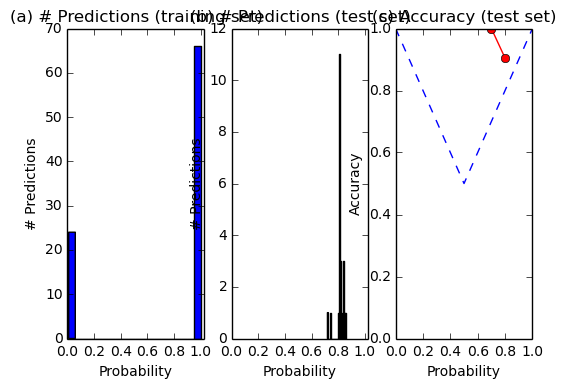

Recall-corrected Noise-aware Model
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Corpus Precision 0.913
Corpus Recall    1.0
Corpus F1        0.955
----------------------------------------
TP: 21 | FP: 2 | TN: 0 | FN: 0

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.5
Neg. class accuracy: 0.0
Corpus Precision 0.913
Corpus Recall    0.5
Corpus F1        0.646
----------------------------------------
TP: 21 | FP: 2 | TN: 0 | FN: 21



In [35]:
tp, fp, tn, fn = disc_model.score(F_dev, L_dev, dev_gold)

In [36]:
from snorkel.models import Corpus
from hardware_utils import entity_level_f1
import os

gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/dev/hardware_dev_gold.csv'
corpus = session.query(Corpus).filter(Corpus.name == 'Hardware Dev').one()
%time (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc=None)
%time (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc=parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.905
Corpus Recall    1.0
Corpus F1        0.95
----------------------------------------
TP: 19 | FP: 2 | FN: 0

CPU times: user 192 ms, sys: 60 ms, total: 252 ms
Wall time: 236 ms
Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.905
Corpus Recall    1.0
Corpus F1        0.95
----------------------------------------
TP: 19 | FP: 2 | FN: 0

CPU times: user 60 ms, sys: 12 ms, total: 72 ms
Wall time: 64.5 ms


### Error Analysis

In [37]:
# from hardware_utils import separate_fns

# unfound, misclassified = separate_fns(FN, cfn)

In [38]:
# pprint(misclassified)

In [39]:
# pprint(unfound)

In [40]:
# from hardware_utils import separate_fps

# bad_part, bad_relation = separate_fps(FP, corpus, gold_file)

In [41]:
# pprint(bad_relation)

In [42]:
# pprint(bad_part)

In [43]:
# from pprint import pprint
# pprint([(unicode(x[0]), x[1]) for x in disc_model.get_feature_weights(F_dev)[:100]])

In [44]:
# from hardware_utils import entity_to_candidates

# entity = FP[0]
# print entity
# print

# matches = entity_to_candidates(entity, fp)
# print "# Matches: %d" % len(matches)
# print

# candidate = matches[0]
# print candidate
# print

# from hardware_utils import part_error_analysis
# part_error_analysis(candidate)

# pprint(disc_model.get_candidate_feature_weights(candidate, F_dev))

### Oracle

In [45]:
from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
from snorkel.utils import get_ORM_instance
from snorkel.models import Corpus

parts_by_doc = get_gold_parts_by_doc()
(TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc)

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.905
Corpus Recall    1.0
Corpus F1        0.95
----------------------------------------
TP: 19 | FP: 2 | FN: 0



### Test Results

Calibration plot:


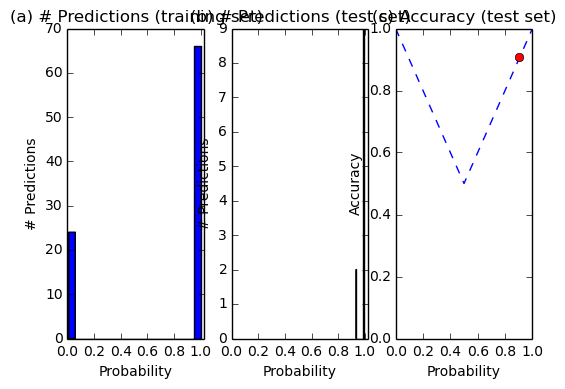

Recall-corrected Noise-aware Model
Pos. class accuracy: 1.0
Neg. class accuracy: 0.0
Corpus Precision 0.909
Corpus Recall    1.0
Corpus F1        0.952
----------------------------------------
TP: 10 | FP: 1 | TN: 0 | FN: 0

Recall-corrected Noise-aware Model
Pos. class accuracy: 0.322580645161
Neg. class accuracy: 0.0
Corpus Precision 0.909
Corpus Recall    0.323
Corpus F1        0.476
----------------------------------------
TP: 10 | FP: 1 | TN: 0 | FN: 21

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.75
Corpus Recall    0.6
Corpus F1        0.667
----------------------------------------
TP: 3 | FP: 1 | FN: 2

Preparing candidates...
[========================================] 100%
Scoring on Entity-Level Gold Data
Corpus Precision 0.75
Corpus Recall    0.6
Corpus F1        0.667
----------------------------------------
TP: 3 | FP: 1 | FN: 2



In [46]:
if TEST_SIZE:
    from snorkel.annotations import LabelManager
    label_manager = LabelManager()
    L_test = label_manager.load(session, test, 'Hardware Test Labels -- Gold')
    L_test.shape
    
    tp, fp, tn, fn = disc_model.score(F_test, L_test, dev_gold)
    
    from hardware_utils import get_gold_parts_by_doc, get_manual_parts_by_doc
    from snorkel.utils import get_ORM_instance
    from snorkel.models import Corpus

    corpus = get_ORM_instance(Corpus, session, 'Hardware Test')

    # parts_by_doc_test = get_manual_parts_by_doc(corpus.documents.all())
    # parts_by_doc_test = None
    import cPickle as pickle
    pickle_file = os.environ['SNORKELHOME'] + '/tutorials/tables/sandbox/parts_by_doc_test.pkl'
    with open(pickle_file, 'r') as f:
        parts_by_doc_test = pickle.load(f)

    from snorkel.models import Corpus
    from hardware_utils import entity_level_f1
    import os

    gold_file = os.environ['SNORKELHOME'] + '/tutorials/tables/data/hardware/test/hardware_test_gold.csv'
    (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus)
    (TP, FP, FN) = entity_level_f1(tp.union(fp), gold_file, ATTRIBUTE, corpus, parts_by_doc_test)